# Constrained feature matching.

After achieving a lot of matches, we want to filter them based on geometric constraints.\
The F matrix constraints points to a line, so we will use our matches to RANSAC estimate F, \
and then remove outliers matches after finding our best F from RANSAC.

### The Eight Point Algorithm
Here you will write a function that uses the eight point algorithm for fundamental matrix estimation. This should be a slight modification of your algorithm for homography estimation. \
As for
the homography estimation the data points should also be normalized. \
Find the fundamental matrix that you computed for the images in TwoImageData.npy in week 3
and denote it Ftrue.

In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import utilis

In [2]:
fest = np.load('images/Fest_test.npy', allow_pickle=True).item()
fest.keys()

dict_keys(['q1', 'q2', 'Ftrue'])

In [3]:
Ftrue = fest['Ftrue']
#####################################
q1 = fest["q1"]
q2 = fest["q2"]

print(Ftrue)
q1.shape ### 2D homogeneous coordinates

[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]


(3, 8)

### 9.1 SVD F approximator

Implement a function Fest_8point that estimates a fundamental matrix from eight (or more point) \
correspondences, using the linear algorithm. Use the points in qs.npy to estimate a fundamental \
 matrix, and check that your estimated fundamental matrix is identical to Ftrue up to scale and numerical error


First, a quick look at normalization: 

1. From homography we had: Hq2 = q1, so H' (T2@q2) = T1@q1 => H = T1.inv @ H' @ T2
2. Now we have: q2.T@F@q1 = 0, so (T2@q2).T @ F' @ (T1@q1) = 0 => F = T2.T @ F' @ T1

Text(0.5, 1.0, 'Normed points')

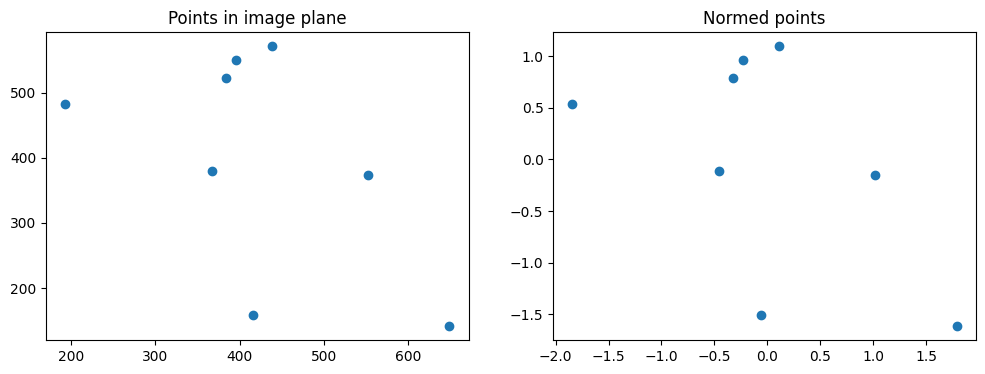

In [4]:
###################
## Normalization ##
###################
mean = np.mean(q1,axis=1)
std = np.std(q1,axis=1)
T = np.array([[1/std[0],0,-mean[0]/std[0]],
                [0,1/std[1],-mean[1]/std[1]],
                [0,0,1]])
                
normed_q1 = T@q1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].scatter(q1[0,:], q1[1, :])
ax[0].set_title("Points in image plane")
ax[1].scatter(normed_q1[0,:], normed_q1[1, :])
ax[1].set_title("Normed points")

In [5]:
def get_B(q1,q2):
    B = np.array([q1[0, 0]*q2[0, 0], q1[0, 0]*q2[1, 0], q1[0, 0],
                  q1[1, 0]*q2[0, 0], q1[1, 0]*q2[1, 0], q1[1, 0],
                  q2[0, 0], q2[1, 0], 1])
    for i in range(1,len(q1[0])):
        B_new_row = np.array([q1[0, i]*q2[0, i], q1[0, i]*q2[1, i], q1[0, i],
                              q1[1, i]*q2[0, i], q1[1, i]*q2[1, i], q1[1, i],
                              q2[0, i], q2[1, i], 1])
        B = np.vstack((B,B_new_row))
    return B

def normalize2d(Q):
    mean = np.mean(Q,axis=1)
    std = np.std(Q,axis=1)
    T = np.array([[1/std[0],0,-mean[0]/std[0]],
                  [0,1/std[1],-mean[1]/std[1]],
                 [0,0,1]])
    return [T@Q, T]

In [6]:
def Fest_8point(q1, q2, normalize=True):
    # Normalize the points
    if normalize:
        q1,T1 = normalize2d(q1)
        q2,T2 = normalize2d(q2)
    # Construct the B matrix from the matching points
    B = get_B(q1, q2)
    # Run the SVD algorithm: 0 = B@Flatten(F.T)
    _,_,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(np.hstack((B.T,B)))
    # VT is sorted in descending order of singular value
    F_vec = VT[-1]
    F = np.array([[F_vec[0], F_vec[3], F_vec[6]],
                  [F_vec[1], F_vec[4], F_vec[7]],
                  [F_vec[2], F_vec[5], F_vec[8]]])
    if normalize:
        #return (np.linalg.inv(T1)@F.T@T2.round(2))
        return T2.T@F@T1
    else:
        return F

In [23]:
Fest = Fest_8point(q1, q2, normalize=False)
#up to scale and numerical error.
Fest = Fest/Fest[0, 0] * Ftrue[0, 0]

print(q1.shape)
print(Fest)
print(Ftrue)
print(np.linalg.norm(Fest - Ftrue))

(3, 8)
[[ 6.67972386e-12 -7.84933721e-10  1.17901072e-07]
 [-9.75808989e-10 -4.86753293e-12  3.28654116e-05]
 [ 4.23451561e-07 -3.21659959e-05 -2.11973093e-04]]
[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]
2.981056189624966e-08


## Feature matching

### 9.2 Make SIFT matches 
Repeat part of the exercise from last week, by matching the two images from TwoImageData.npy. \
However, this time do not filter matches by the ratio test, only use cross checking as done by \
cv2.BFMatcher_create(crossCheck=True). Visualize the result and confirm that it looks reasonable \
compared to your expectations.


```Java
CrossCheck which is false by default. If it is true, Matcher returns only those matches with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match and vice-versa. That is, the two features in both sets should match each other. It provides consistant result, and is a good alternative to ratio test proposed by D.Lowe in SIFT paper.
```

In [8]:
two_image = np.load('images/TwoImageData.npy', allow_pickle=True).item()
two_image.keys()

dict_keys(['im1', 'im2', 'R1', 'R2', 't1', 't2', 'K'])

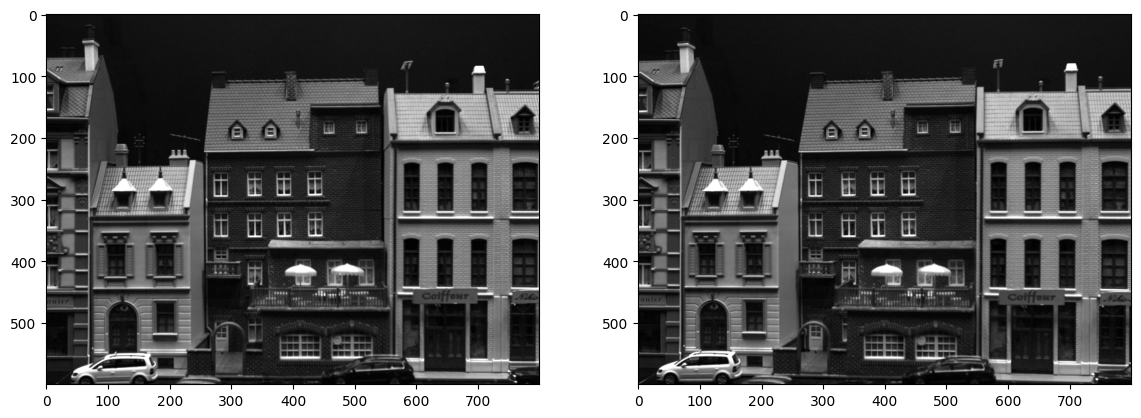

In [9]:
grey_left = two_image['im1']
grey_right = two_image['im2']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
axs[0].imshow(grey_left, cmap="gray")
axs[1].imshow(grey_right , cmap="gray")

In [10]:
# Use SIFT to getkeypoints and their descriptors
sift = cv2.xfeatures2d.SIFT_create() # Sigma of the gaussian at octave 0
kp1, des1 = sift.detectAndCompute(grey_left, None) #Keypoints and descriptors
kp2, des2 = sift.detectAndCompute(grey_right, None) #Keypoints and descriptors

SIFT WITHOUT RATIO TEST

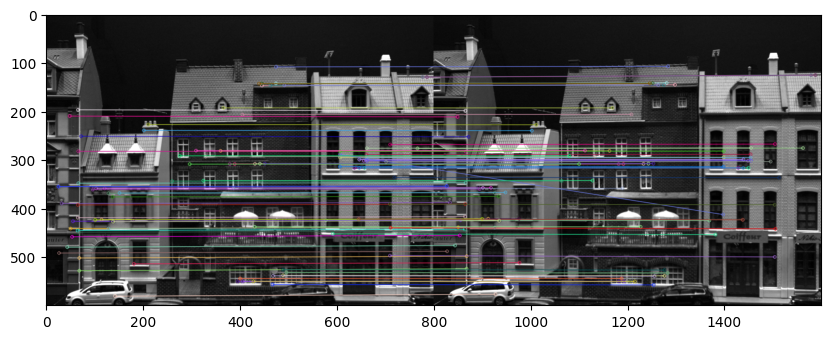

In [11]:
# Match using brute force matcher, with crossCheck.
bf = cv2.BFMatcher_create(crossCheck=True)
matches = bf.match(des1, des2)
sorted_matches = sorted(matches, key = lambda x:x.distance)
len(matches)

mimg = cv2.drawMatches(grey_left, kp1, grey_right, kp2, sorted_matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (10,10))
plt.imshow(mimg)

## Fundamental matrix estimation via RANSAC
Make a copy of your RANSAC algorithm that fits straight lines, and modify it to fit fundamental
matrices instead.

### 9.3 RANSAC
Sample eight random matches. This can be done with the following code ```np.random.choice(matches, 8, replace=False).``` \
Use your function Fest_8point to estimate the fundamental matrix from these eight matches. Write a function ```SampsonsDistance(F, p1, p2)``` \
that computes Sampson’s distance. Set points to inliers if their Sampson’s distance is less than 3.84 · 3ˆ2. Explain where this value \
comes from. Repeat the above steps for the a fixed number of iterations, such as 200. Use your ```Fest_8point``` to estimate the final fundamental matrix using all inliers of the best model. \
Run your algorithm on the the images from TwoImageData.npy. Compare your estimated F to Ftrue. 

You could use the following code to compare them:\
```(F*Ftrue).sum() / (np.linalg.norm(F)*np.linalg.norm(Ftrue))```\
Explain what this code does.

Distance Measures: Essential for evaluating the quality of a fit. Sampson's distance is commonly used for its practical performance.

In [12]:
def SampsonsDistance(F, q1, q2):
    """
    params:
        - p1, p2 is 3x1 homogenous matching points
        - F is a 3x3 proposed fundamental matrix

    return: sampson distance between points
    """
    a1 = (q2.T@F)[0]**2
    b1 = (q2.T@F)[1]**2
    a2 = (F@q1)[0]**2
    b2 = (F@q1)[1]**2

    return (q2.T@F@q1)**2 * 1/(a1 + b1 + a2 + b2)

In [13]:
dist_samp= SampsonsDistance(Ftrue, q1[:, 0], q2[:, 0])
print("Two matching points:", dist_samp, "(~ 0)")
print("Two non-matching points:", SampsonsDistance(Ftrue, q1[:, 1], q2[:, 0]))

print(q1[:, 0])


Two matching points: 5.71285626806206e-27 (~ 0)
Two non-matching points: 799.8855931222687
[192.80308677 482.655306     1.        ]


How to decide the threshold ? The threshold determines whether a data point fits the model well enough to be considered an inlier. \ 
It depends on the Codimension (m): \
The codimension m refers to the dimensionality of the error:

- Fundamental matrix: 
m=1
- Homography: 
m=2
- Pose estimation: 
m=2

In [28]:
from scipy.stats import chi2

def compute_threshold(codimension, confidence_level, sigma):
    # Find the chi-squared value for the given confidence level and codimension
    chi_squared_value = chi2.ppf(confidence_level, codimension)
    # Compute the threshold
    threshold = np.sqrt(chi_squared_value * sigma**2)
    return threshold
codimension_fundamental = 1  # For fundamental matrix
sigma =3
confidence_level = 0.95  

threshold_fundamental = compute_threshold(codimension_fundamental, confidence_level, sigma)
print(f"Threshold for Fundamental Matrix: {threshold_fundamental}")


Threshold for Fundamental Matrix: 5.879891953620161


In [14]:
def consensus_F(Fest, q1, q2, sigma):
    threshold = 3.84*sigma**2
    inliers_index = []
    for i in range(len(q1[0])):
        sdist = SampsonsDistance(Fest, q1[:, i], q2[:, i])
        if sdist<threshold:
            inliers_index.append(i)
    return len(inliers_index), np.asarray(inliers_index)

The ransac_fundamental_matrix function implements the RANSAC algorithm to robustly estimate the fundamental matrix. It iterates a specified number of times, each time:
1. Randomly sampling 8 point correspondences.
2. Estimating the fundamental matrix using these correspondences.
3. Calculating the number of inliers based on the Sampson distance.
4. Updating the best model if the current one has more inliers.

Threshold Calculation: The threshold is computed using the χ² distribution to ensure a high probability of correctly identifying inliers.


In [15]:
def RANSAC_8_point(p1s, p2s, sigma=3, iterations=500):

    # RANSAC iterations
    best_inliers = 0
    Fbest = None
    for i in range(iterations):
        # Draw eight random matches
        match_idx = np.random.randint(low=0, high=len(p1s[0]), size=(8,))
        q1 = p1s[:, match_idx]
        q2 = p2s[:, match_idx]
        # Estimate the line
        Fest = Fest_8point(q1, q2, normalize=True)
        # Find no. inliers
        no_inliers, _ = consensus_F(Fest, p1s, p2s, sigma)
        if no_inliers>best_inliers:
            Fbest = Fest
            best_inliers = no_inliers
            print(i, "New best estimate!")
    print(f'Num of inliers: {best_inliers}')
    # Now, use all inliers of best F to match a final F
    _, inlier_index = consensus_F(Fbest, p1s, p2s, sigma)
    Final_F = Fest_8point(p1s[:, inlier_index], p2s[:, inlier_index], normalize=True)
    return Final_F, inlier_index, best_inliers

In [16]:
def SIFT_extractor(gray_left, gray_right):
    # Use SIFT to getkeypoints and their descriptors
    sift = cv2.SIFT_create() # Sigma of the gaussian at octave 0
                                    
    kp1, des1 = sift.detectAndCompute(gray_left, None) #Keypoints and descriptors
    kp2, des2 = sift.detectAndCompute(gray_right, None) #Keypoints and descriptors

    # Match using brute force matcher, with crossCheck.
    bf = cv2.BFMatcher_create(crossCheck=True)
    matches = bf.match(des1, des2)

    p1s, p2s = [], []
    for match in matches:
        p1s.append(kp1[match.queryIdx].pt)
        p2s.append(kp2[match.trainIdx].pt)

    return matches, np.asarray(p1s).T, np.asarray(p2s).T, kp1, kp2

In [17]:
# Get all matches and points corresponding to matches
matches, p1s, p2s, _, _ = SIFT_extractor(grey_left, grey_right)
# print(p1s.shape)
p1s = np.vstack((p1s, np.ones(len(p1s[0]))))
p2s = np.vstack((p2s, np.ones(len(p2s[0]))))

# print(p1s)
# print(p1s.shape)

ransac_F, inlier_index,best_inliers  = RANSAC_8_point(p1s, p2s, sigma=3, iterations=1000)
ransac_F = ransac_F/ransac_F[0, 0] * Ftrue[0, 0]
print(len(matches))

0 New best estimate!
1 New best estimate!
7 New best estimate!
10 New best estimate!
14 New best estimate!
17 New best estimate!
72 New best estimate!
102 New best estimate!
560 New best estimate!
Num of inliers: 1930
2086


In [18]:
print(inlier_index)
print("----------------------Final F----------------------")
print(ransac_F)
print("----------------------True F----------------------")
print(Ftrue)
print("\n\n\n----------------------Distances--------------------")
print("True->Ransac:", np.linalg.norm(Ftrue-ransac_F))


[   0    1    3 ... 2083 2084 2085]
----------------------Final F----------------------
[[ 6.67972386e-12  1.31931955e-09 -2.74270012e-07]
 [-6.34118538e-10  4.90555723e-11 -1.19582745e-05]
 [ 5.53582193e-08  1.16663142e-05  8.46789466e-05]]
----------------------True F----------------------
[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]



----------------------Distances--------------------
True->Ransac: 0.0003032346189040535


### 9.4 Self captured images

Find the images you captured last week or capture new ones. Match SIFT features between these \
images using cross checking. Estimate the fundamental matrix between these images using your RANSAC \
algorithm. Comment on how well the fundamental matrix acts as a regularizer on which matches are used.

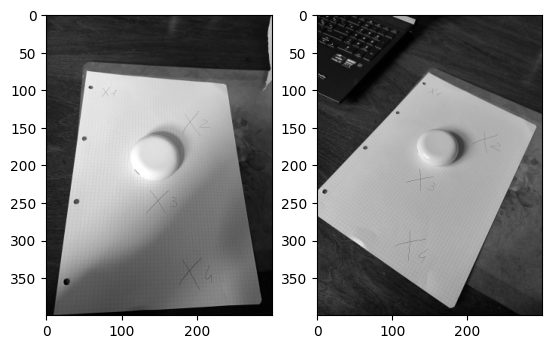

In [19]:
# Load image
left_color = cv2.imread('images/paper_1.jpg')
left = cv2.cvtColor(left_color, cv2.COLOR_RGB2GRAY)
right_color = cv2.imread('images/paper_2.jpg')
right = cv2.cvtColor(right_color, cv2.COLOR_RGB2GRAY)

# Need to scale down images for better visualization
scale_percent = 20 # percent of original size
width = int(right.shape[1] * scale_percent / 100)
height = int(right.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
right = cv2.resize(right, dim, interpolation = cv2.INTER_AREA)
left = cv2.resize(left, dim, interpolation = cv2.INTER_AREA)

# Show
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(right, cmap="gray")
ax[1].imshow(left, cmap="gray")

In [20]:
# Get all matches and points corresponding to matches
matches, p1s, p2s, kp1, kp2 = SIFT_extractor(right, left)
p1s = np.vstack((p1s, np.ones(len(p1s[0]))))
p2s = np.vstack((p2s, np.ones(len(p2s[0]))))

ransac_F, inlier_index,_ = RANSAC_8_point(p1s, p2s, sigma=3, iterations=1000)

0 New best estimate!
3 New best estimate!
5 New best estimate!
92 New best estimate!
213 New best estimate!
Num of inliers: 14


In [21]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a


######## Best inliers matches
inMatches = np.array([matches])[0, inlier_index][:]
inMatches = totuple(inMatches)

p1s, p2s = [], []
for match in matches:
        p1s.append(kp1[match.queryIdx].pt)
        p2s.append(kp2[match.trainIdx].pt)
print(len(matches), len(inMatches), np.asarray(p1s).T)

20 14 [[ 25.40333176  26.75131226  40.09318161  40.09318161  50.54008865
   51.95059967  52.96420288  54.19616318  55.11203003  58.71016693
   60.55864716 157.64266968 225.46723938 235.99604797 235.99604797
  254.871521   257.99349976 262.25991821 273.13061523 279.49398804]
 [275.18963623 355.6444397  249.06062317 249.06062317 165.33442688
  161.45195007 146.99446106  93.05043793  90.7639389   97.27259064
   84.50270844 180.91162109  86.59415436  95.88095856  95.88095856
  178.84727478 199.26023865 224.15661621 289.40939331 379.13922119]]


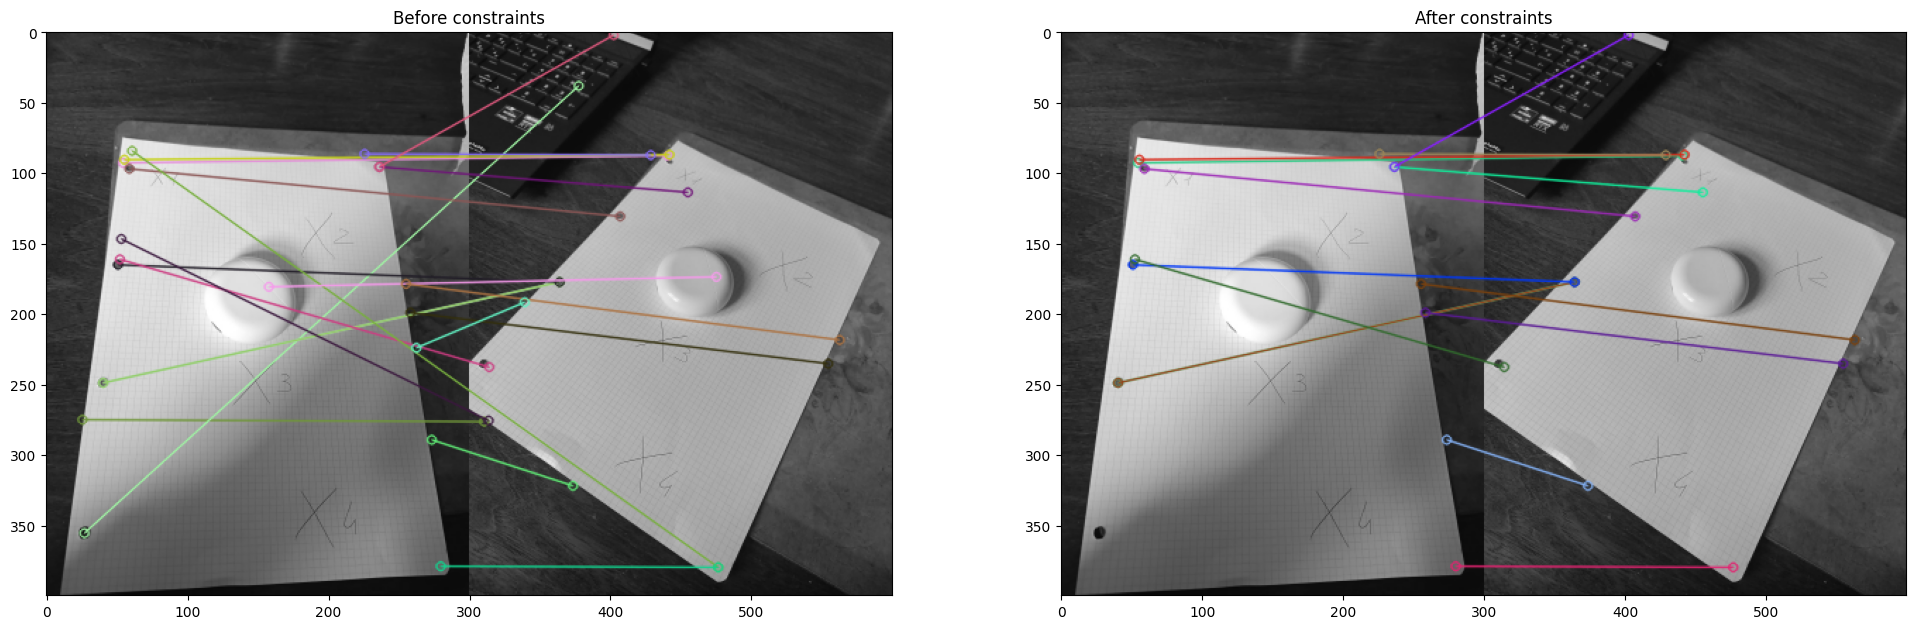

In [22]:
match_frame_before = cv2.drawMatches(right,kp1,left,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
match_frame_after = cv2.drawMatches(right,kp1,left,kp2,inMatches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (24, 12))
axs[0].set_title("Before constraints")
axs[1].set_title("After constraints")
axs[0].imshow(match_frame_before)
axs[1].imshow(match_frame_after)

**WOW!** Look how the fundamental matrix constraint locks all matches withing epipolar lines! That is cool. 

The F is powerful and gave good results, but was slower than say the ratio test. 